In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn.cluster import AgglomerativeClustering
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import seaborn as sns
import matplotlib.font_manager
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
! pip install japanize-matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=e59777a02243d53cd8dc54c9a1b40188fcf121410b3bf18ec53f0455515a38f6
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [3]:
import japanize_matplotlib

Загрузим чистый корпус.

In [5]:
df = pd.read_csv('/content/Akutagawa_corpus_clean_test.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  125 non-null    int64 
 1   Unnamed: 0    125 non-null    int64 
 2   link          125 non-null    object
 3   author        125 non-null    object
 4   year          125 non-null    int64 
 5   title         125 non-null    object
 6   text          125 non-null    object
 7   lemmas        125 non-null    object
dtypes: int64(3), object(5)
memory usage: 7.9+ KB


In [7]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'link', 'author', 'year', 'title', 'text',
       'lemmas'],
      dtype='object')

Удалим ненужные колонки.


In [8]:
df=df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [9]:
df.head()

,link,author,year,title,text,lemmas
0,https://www.aozora.gr.jp/cards/000879/files/48...,芥川龍之介,1920,愛読書の印象,\n愛読書の印象\n芥川龍之介\n\n\n\n\n 子供の時の愛読書は「西遊記」が第一である...,\n 愛読 印象 \n 芥川 龍之介 \n\n\n\n\n 子供 愛読 西遊 記 今日 僕...
1,https://www.aozora.gr.jp/cards/000879/files/15...,芥川龍之介,1920,アグニの神,\nアグニの神\n芥川龍之介\n\n\n\n\n 一\n\n 支那の上海の或町で...,\n アグニ 神 \n 芥川 龍之介 \n\n\n\n\n \n\n 支那 ...
2,https://www.aozora.gr.jp/cards/000879/files/43...,芥川龍之介,1920,アグニの神,\nアグニの神\n芥川龍之介\n\n\n\n\n 一\n\n 支那の上海の或町です...,\n アグニ 神 \n 芥川 龍之介 \n\n\n\n\n \n\n 支那 上...
3,https://www.aozora.gr.jp/cards/000879/files/38...,芥川龍之介,1918,悪魔,\n悪魔\n芥川龍之介\n\n\n\n\n 伴天連うるがんの眼には、外の人の見えないものまで...,\n 悪魔 \n 芥川 龍之介 \n\n\n\n\n 伴天連 うる がん 眼 見える 見え...
4,https://www.aozora.gr.jp/cards/000879/files/14...,芥川龍之介,1923,あばばばば,\nあばばばば\n芥川龍之介\n\n\n\n\n 保吉はずつと以前からこの店の主人を見知つて...,\n ばばば \n 芥川 龍之介 \n\n\n\n\n 保吉 ずつと 主人 見知 つう ゐ...


Векторизуем тексты.

In [10]:
X = df['lemmas']

In [11]:
y = df['year']

In [12]:
tf_idf = TfidfVectorizer()

In [13]:
tf_idf.fit(X)

TfidfVectorizer()

In [14]:
X_vec = tf_idf.transform(X)

## Кластеризация произведений

С помощью метода локтя определим лучшее количество кластеров.

In [15]:
max_cluster = 20
clusters = range(1, max_cluster)
intra_sum_of_square_list = []

for k in clusters:
    km = KMeans(n_clusters=k)
    km.fit(X_vec)
    intra_sum_of_square_list.append(km.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


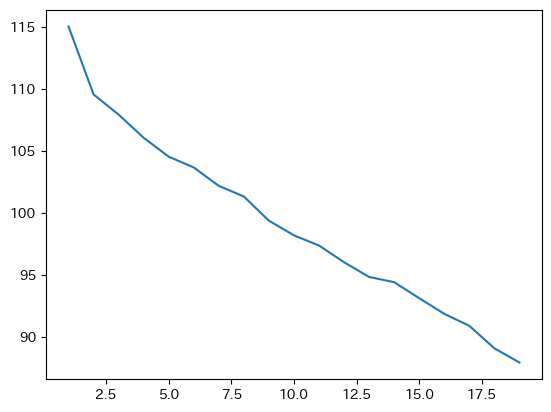

In [16]:
plt.plot(clusters, intra_sum_of_square_list)

Метод показывает, что кластер всего один.

Воспользуемся коэффициентом силуэта, чтобы выяснить оптимальное количество кластеров.

In [17]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_vec)

In [18]:
samples_silhouettes = silhouette_samples(X_vec, kmeans.labels_)

In [19]:
silhouette_avg = silhouette_score(X_vec, kmeans.labels_)

In [20]:
def plot_silhouettes(samples_silhouettes, labels, n_clusters, silhouette_avg):
  fig, ax = plt.subplots()
  y_lower = 10

  for i in range(n_clusters):
      ith_cluster_silhouette_values = samples_silhouettes[labels == i]
      ith_cluster_silhouette_values.sort()
      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i


      ax.fill_betweenx(np.arange(y_lower,y_upper),
                      0,
                      ith_cluster_silhouette_values,
                      alpha=0.3)

      #label the silhouse plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      #compute the new y_lower for next plot
      y_lower = y_upper +10

  ax.set_title("Silhuoette plot")
  ax.set_xlabel("silhouette score")
  ax.set_ylabel("Cluster label")

  #the vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax.set_yticks([])
  ax.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1])

  plt.show()

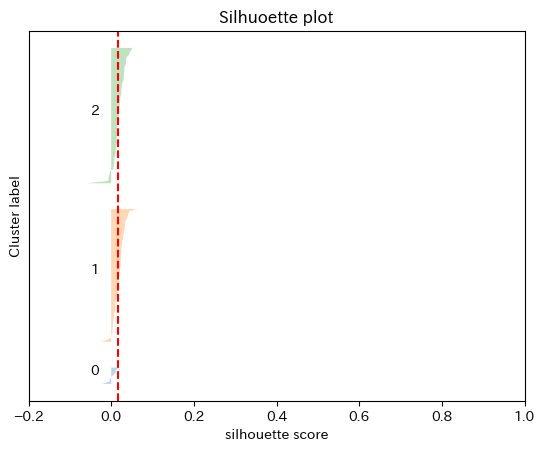

In [21]:
plot_silhouettes(samples_silhouettes, kmeans.labels_, 3, silhouette_avg)

In [22]:
kmeans_5 = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X_vec)
kmeans_7 = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(X_vec)
kmeans_14 = KMeans(n_clusters=14, random_state=0, n_init="auto").fit(X_vec)

In [23]:
samples_silhouettes_5 = silhouette_samples(X_vec, kmeans_5.labels_)
silhouette_avg_5 = silhouette_score(X_vec, kmeans_5.labels_)

In [24]:
samples_silhouettes_7 = silhouette_samples(X_vec, kmeans_7.labels_)
silhouette_avg_7 = silhouette_score(X_vec, kmeans_7.labels_)

In [25]:
samples_silhouettes_14 = silhouette_samples(X_vec, kmeans_14.labels_)
silhouette_avg_14 = silhouette_score(X_vec, kmeans_14.labels_)

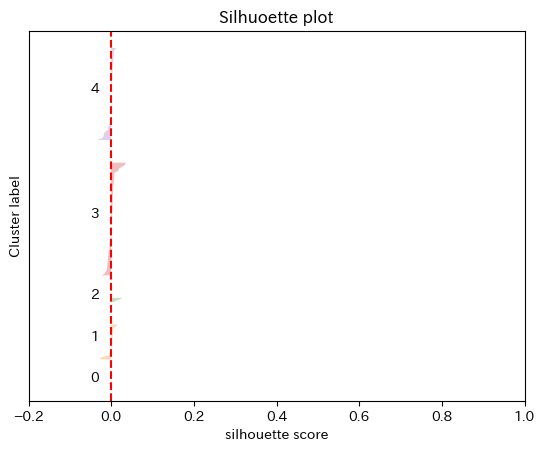

In [26]:
plot_silhouettes(samples_silhouettes_5, kmeans_5.labels_, 5, silhouette_avg_5)

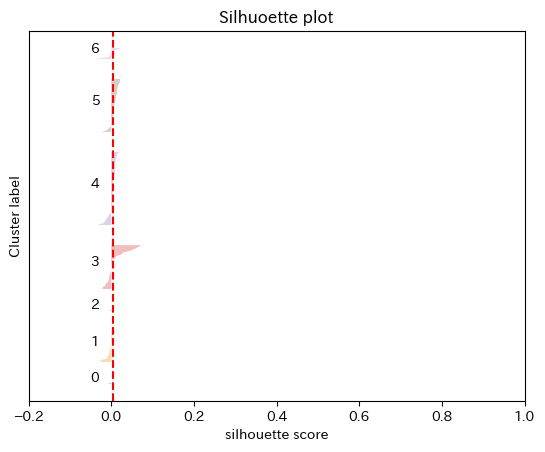

In [27]:
plot_silhouettes(samples_silhouettes_7, kmeans_7.labels_, 7, silhouette_avg_7)

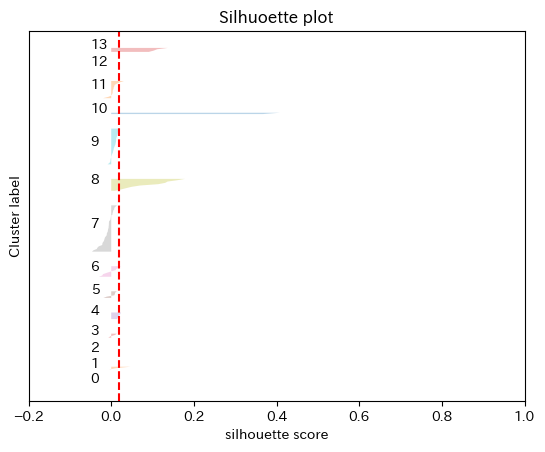

In [28]:
plot_silhouettes(samples_silhouettes_14, kmeans_14.labels_, 14, silhouette_avg_14)

Коэффициент силуэта говорит, что оптимальное количество кластеров среди 3, 5, 7 и 14 это 3. Но видно, что кластеры трудно выделяются.

Попробуем оценить качество этой кластеризации.

In [29]:
print(rand_score(y, kmeans.labels_))

0.5531612903225807


In [30]:
print(adjusted_rand_score(y, kmeans.labels_))

0.0021328384620629966


In [31]:
print(homogeneity_completeness_v_measure(y, kmeans.labels_))

(0.04717686985677889, 0.13388678357362005, 0.06976948983991875)


Качество кластеризации (3 кластера) не высокое.

## DBSCAN (Density-based spatial clustering of applications with noise)

In [32]:
clustering = DBSCAN(eps=3, min_samples=2).fit(X_vec)

In [33]:
clustering.labels_.shape

(125,)

In [34]:
labels=clustering.labels_

In [35]:
X_vec[:,0]

<125x1 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [36]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 1


DBSCAN так же, как и k-means, предполагает наличие только 1 кластера.

## Иерархическая кластеризация

In [37]:
X_vec2 = X_vec.toarray()

In [38]:
def clustering(X_vec):

    range_n_clusters = [3, 5, 7, 14]
    silhouette_values = {}
    for n_clusters in range_n_clusters:

        clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        y_predict = clusterer.fit_predict(X_vec)
        cluster_labels = clusterer.labels_

        silhouette_avg = silhouette_score(X_vec, cluster_labels)
        print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
        silhouette_values[n_clusters] = silhouette_avg

In [39]:
clustering(X_vec2)

For n_clusters = 3 The average silhouette_score is : 0.02283055034875156
For n_clusters = 5 The average silhouette_score is : 0.013139840182450083
For n_clusters = 7 The average silhouette_score is : 0.028900851595442645
For n_clusters = 14 The average silhouette_score is : 0.03542417590158793


Идеальный коэффициент силуэта равен 1. Выше видно, что все метрики почти равны нулю. Лучший коэффициент у кластеризации на 14 кластеров.

Выделим 3 кластера и попробуем сравнить их между собой.

In [40]:
agglo = AgglomerativeClustering(n_clusters=3).fit(X_vec2)

In [41]:
agglo

AgglomerativeClustering(n_clusters=3)

In [42]:
agglo.labels_

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 0])

In [43]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

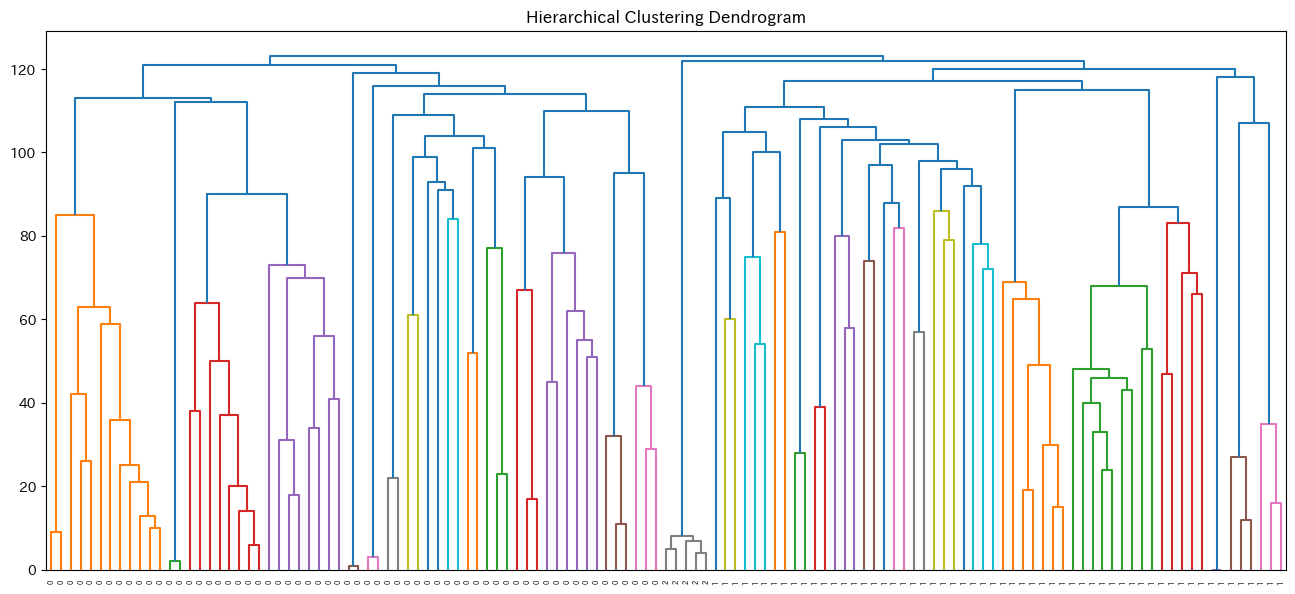

In [44]:
plt.figure(figsize=(16,7))
plot_dendrogram(agglo, labels=agglo.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Видно, что примерно одинаковое количество текстов расположены в нулевом и единичном кластере. Кластер под номером 2 значительно меньше.

In [45]:
df['cluster']=agglo.labels_

In [46]:
agglo.labels_=agglo.labels_.tolist()

In [47]:
df.loc[:, 'cluster']=agglo.labels_

In [48]:
cluster0=df[df['cluster']==0]

In [49]:
cluster1=df[df['cluster']==1]

In [50]:
cluster2=df[df['cluster']==2]

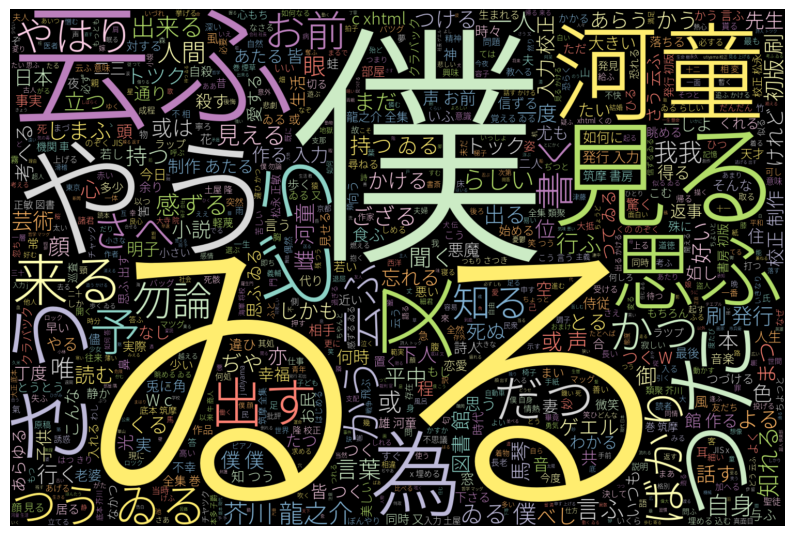

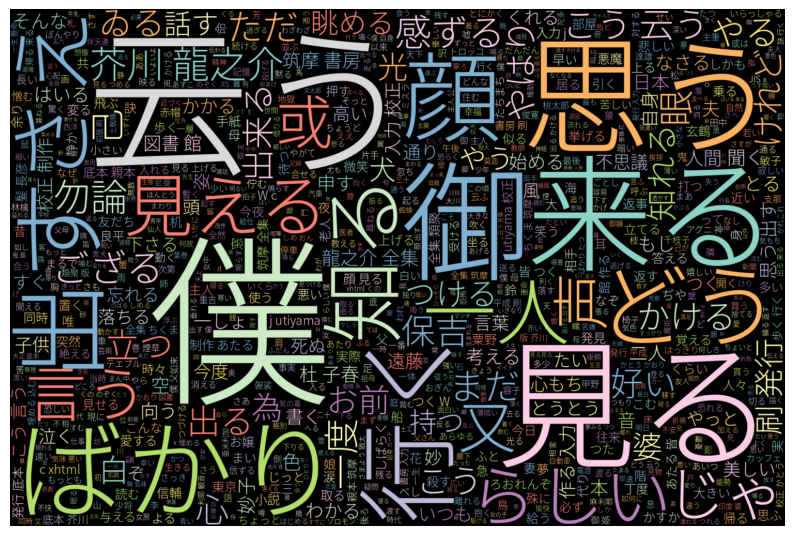

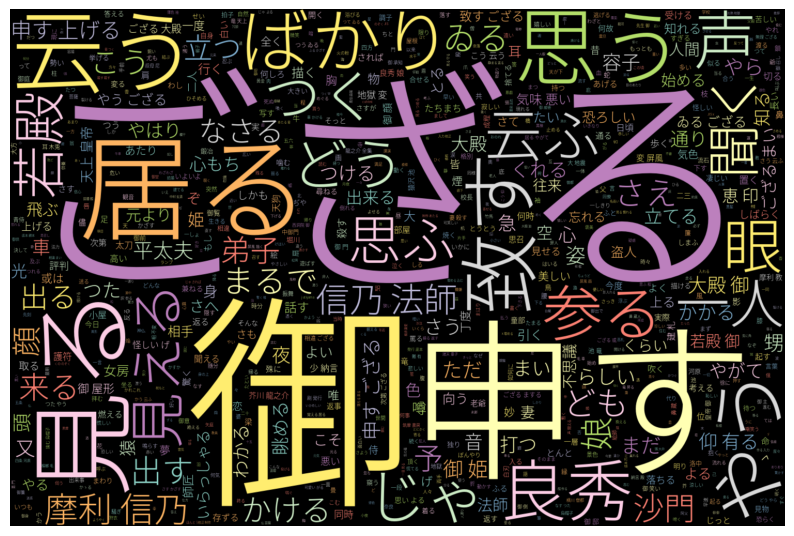

In [51]:
 clusters = [cluster0, cluster1, cluster2]
 for cluster in clusters:
  font_path = 'NotoSansCJKjp-Light.otf'

  wordcloud2 = WordCloud(width=1500,
                      height=1000,
                      background_color='black',
                      max_words=900,
                      colormap='Set3',
                      font_path=font_path,
                      #stopwords = stop_words,
                      normalize_plurals=True).generate(' '.join(cluster['lemmas']))

  plt.figure(figsize=(10,8))
  plt.imshow(wordcloud2, interpolation='bilinear')
  plt.axis("off")
  plt.show()


Видно, что последний кластер (кластер под номером 2) отличается более всего.

Сравним наиболее частотные в этих кластерах слова.

In [52]:
for c in clusters:
  s = ','.join(c['lemmas'].astype(str).values)
  c_w = Counter(s).most_common(10)
  print(c_w)

[(' ', 73269), ('る', 9881), ('\n', 6337), ('\u3000', 5464), ('つ', 2942), ('う', 2601), ('い', 2555), ('ふ', 2352), ('ゐ', 2002), ('く', 1942)]
[(' ', 73888), ('る', 10349), ('\n', 5368), ('う', 3681), ('い', 3609), ('\u3000', 2865), ('く', 2550), ('す', 2451), ('し', 1940), ('か', 1778)]
[(' ', 23903), ('る', 4352), ('い', 1259), ('す', 1185), ('う', 1083), ('御', 953), ('ざ', 938), ('\n', 923), ('く', 909), ('ご', 874)]


## Топики: LDA (Latent Dirichlet Allocation)

In [53]:
lda = LatentDirichletAllocation(n_components=100)

In [54]:
lda.fit(X_vec)

LatentDirichletAllocation(n_components=100)

In [55]:
n_top_words = 10

In [56]:
top_features_ind = lda.components_[0].argsort()[:-n_top_words - 1:-1]

In [57]:
tf_feature_names = tf_idf.get_feature_names_out()

top_features = [tf_feature_names[i] for i in top_features_ind]

In [58]:
weights = lda.components_[0][top_features_ind]

In [59]:
print(top_features, weights)

['蜃気', '砂浜', 'マッチ', '引地', '浪打ち', '陽炎', '笹垣', '錯覚', 'なあ', '運転'] [0.33914057 0.33280157 0.19895887 0.19130881 0.14361209 0.11878528
 0.11878528 0.11020887 0.09940431 0.0955479 ]


In [60]:
def plot_top_words(model, feature_names, title, n_top_words=10, max_plots=5):

    fig, axes = plt.subplots(1, max_plots, figsize=(25, 10)) # параметры отображения
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем


    for topic_idx, topic in enumerate(model.components_):
      if topic_idx < max_plots:
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]

        # строка для сохранения темы и слов в словарь
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=14)


    plt.show()

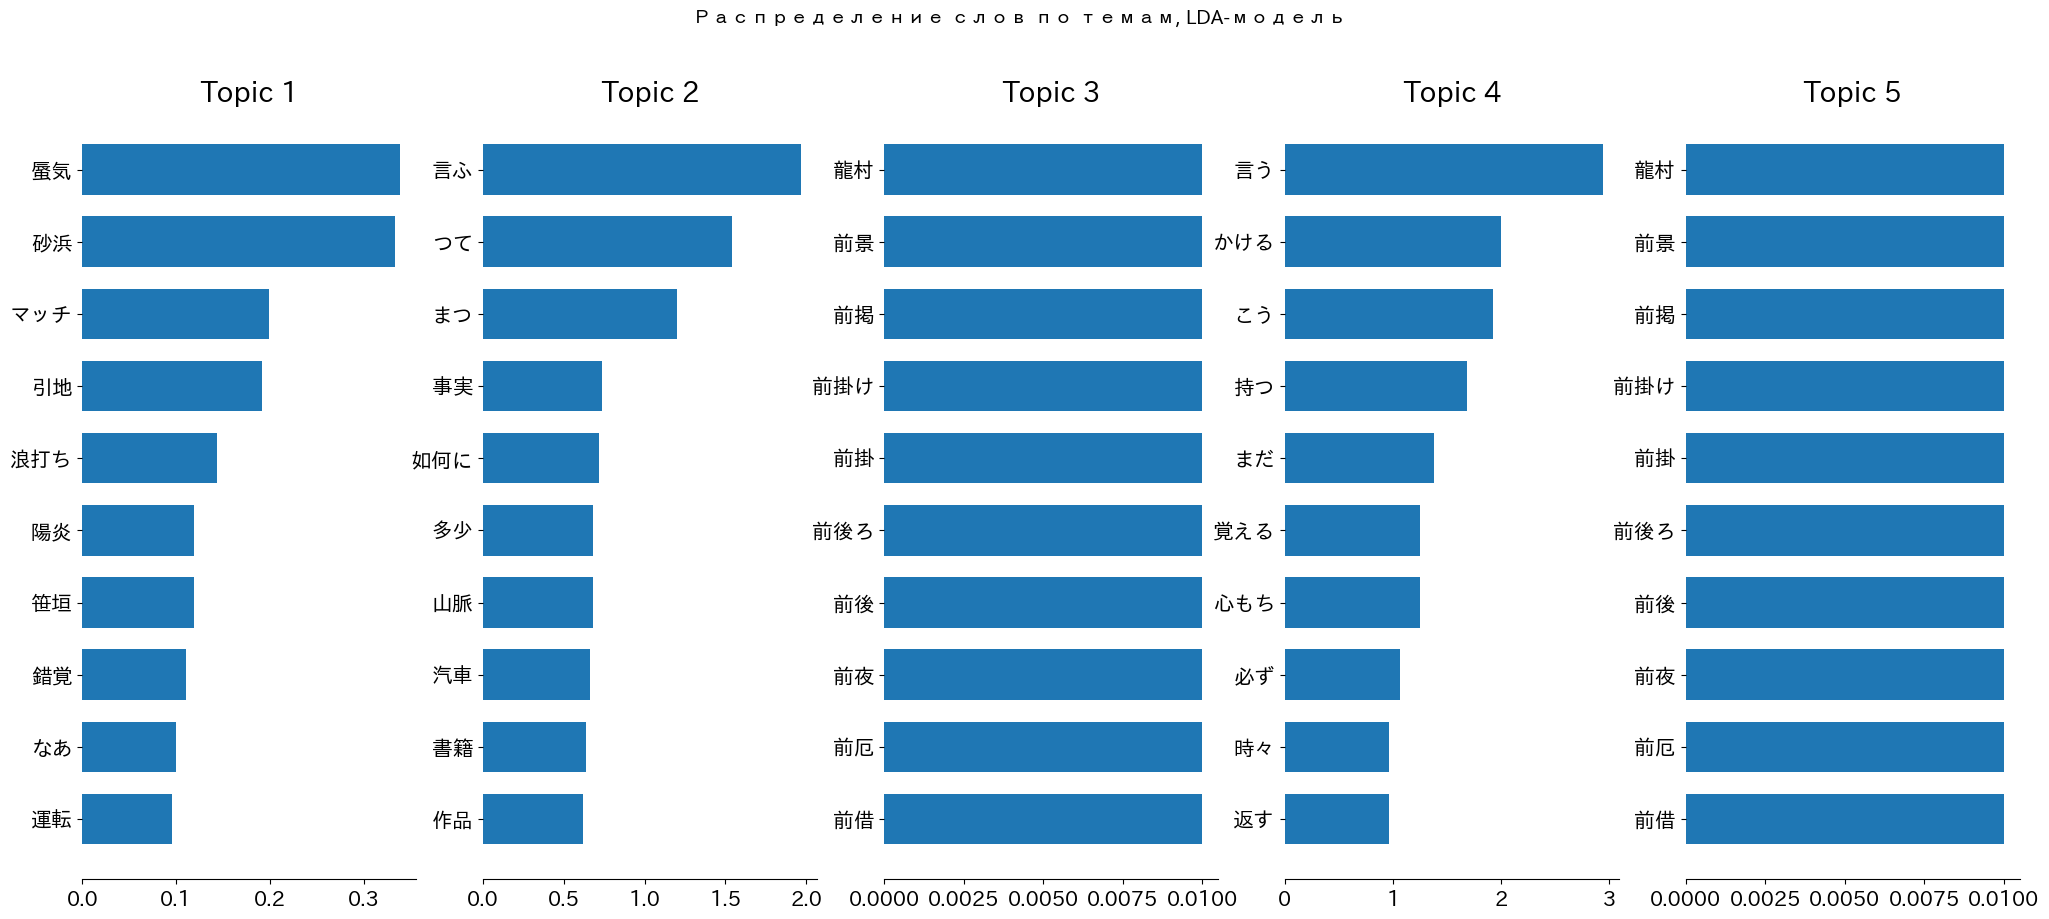

In [61]:
plot_top_words(lda, tf_feature_names, 'Распределение слов по темам, LDA-модель')

## Классификация по дате написания произведения

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmas'], df['year'], test_size=0.2, random_state=42)

In [63]:
tf_idf = TfidfVectorizer()

In [64]:
tf_idf.fit(X_train)

TfidfVectorizer()

In [65]:
X_train_vec = tf_idf.transform(X_train)
X_test_vec = tf_idf.transform(X_test)

Начнем с наивного Байеса.

In [66]:
nb = MultinomialNB()

In [67]:
nb.fit(X_train_vec, y_train)

MultinomialNB()

In [68]:
y_pred = nb.predict(X_test_vec)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1916       0.00      0.00      0.00         1
        1917       0.00      0.00      0.00         1
        1918       0.29      1.00      0.44         2
        1919       0.00      0.00      0.00         3
        1920       0.00      0.00      0.00         2
        1921       0.00      0.00      0.00         1
        1923       0.00      0.00      0.00         3
        1924       0.00      0.00      0.00         1
        1925       0.00      0.00      0.00         1
        1926       0.21      0.75      0.33         4
        1927       0.00      0.00      0.00         6

    accuracy                           0.20        25
   macro avg       0.05      0.16      0.07        25
weighted avg       0.06      0.20      0.09        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Получилась модель невысокого качества.

Попробуем логистическую регрессию.

In [70]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')

In [71]:
logreg.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [72]:
y_pred = logreg.predict(X_test_vec)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1916       0.00      0.00      0.00         1
        1917       0.00      0.00      0.00         1
        1918       0.33      0.50      0.40         2
        1919       0.00      0.00      0.00         3
        1920       0.00      0.00      0.00         2
        1921       0.00      0.00      0.00         1
        1923       0.00      0.00      0.00         3
        1924       0.00      0.00      0.00         1
        1925       0.17      1.00      0.29         1
        1926       0.50      0.25      0.33         4
        1927       0.40      0.33      0.36         6

    accuracy                           0.20        25
   macro avg       0.13      0.19      0.13        25
weighted avg       0.21      0.20      0.18        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Логистическая регрессия показала результаты чуть лучше.

Загрузим произведения, для которых не известны года написания, и попробуем предсказать эти года.

In [74]:
df3=pd.read_csv('/content/Akutagawa_corpus_clean_no_year.csv')

In [75]:
def creation_year(text):
  if not isinstance(text, (list, tuple)):
    text=[text]

  text_vec=tf_idf.transform(text)
  prediction = logreg.predict(text_vec)[0]
  return prediction

In [76]:
df3['year']=df3['text'].apply(creation_year)

In [77]:
df3['year'].head()

0    1925
1    1920
2    1925
3    1925
4    1925
Name: year, dtype: int64

In [78]:
grouped3 = df3.groupby('year').count()


In [79]:
grouped3

,Unnamed: 0,link,author,title,text,lemmas
year,,,,,,
1914,1,1,1,1,1,1
1918,5,5,5,5,5,5
1920,4,4,4,4,4,4
1922,6,6,6,6,6,6
1924,3,3,3,3,3,3
1925,233,233,233,233,233,233
1927,1,1,1,1,1,1


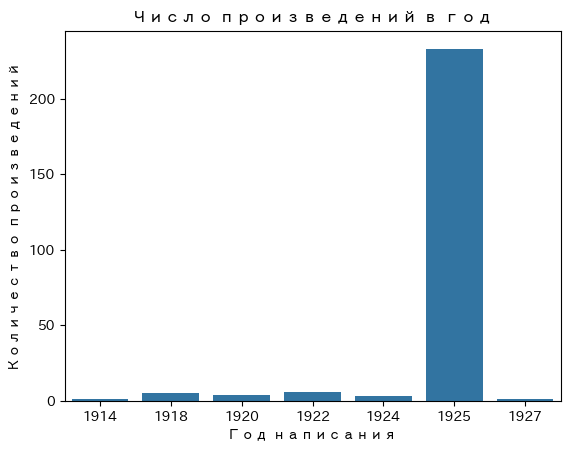

In [80]:
sns.barplot(x = grouped3.index,
            y = 'title',
            data = grouped3)

plt.title("Число произведений в год")
plt.xlabel('Год написания')
plt.ylabel('Количество произведений')
plt.show()

Модель приписала бОльшую часть произведений 1925 году, что явно нереалистично.

Попробуем посмотреть на достоверное распределение произведений по годам.

In [81]:
grouped = df.groupby('year').count()

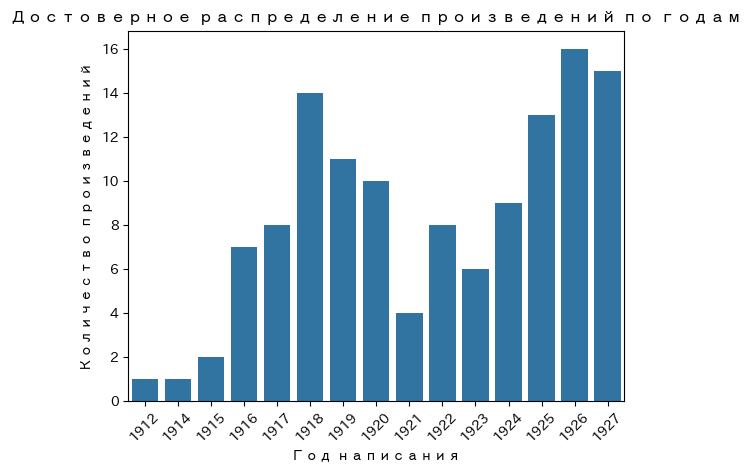

In [83]:
sns.barplot(x = grouped.index,
            y = 'title',
            data = grouped)

plt.title("Достоверное распределение произведений по годам")
plt.xlabel('Год написания')
plt.ylabel('Количество произведений')
plt.xticks(rotation=45)
plt.show()

Из графика видно, что последние годы жизни писателя были особенно продуктивными.